### 네이버 영화리뷰 감성분석 도전하기

#### > 데이터 준비 및 확인

In [1]:
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### > 데이터 로더 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있으므로,
data_loader를 만들어 보는 것으로 시작한다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# load_data 함수
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


In [5]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


#### > 모델 구성을 위한 데이터 분석 및 가공

In [6]:
# 전체문장 길이를 알아낸 후 적절한 값을 넣는 것이 성능에 도움이 됨

total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# padding의 위치에 따라 달라질 수 있다.
# pre
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


#### > 모델 구성 및 validation set 구성

In [8]:
# LSTM
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [10]:
# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation set 10000건 분리
x_val = x_train[:100000]   
y_val = y_train[:100000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[100000:]  
partial_y_train = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(46182, 41)
(46182,)


 #### > 모델 훈련 개시

In [12]:
# LSTM
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/10
91/91 [==============================] - 4s 14ms/step - loss: 0.6926 - accuracy: 0.5049 - val_loss: 0.6894 - val_accuracy: 0.5759
Epoch 2/10
91/91 [==============================] - 1s 10ms/step - loss: 0.5270 - accuracy: 0.7569 - val_loss: 0.4274 - val_accuracy: 0.8195
Epoch 3/10
91/91 [==============================] - 1s 9ms/step - loss: 0.3625 - accuracy: 0.8549 - val_loss: 0.3784 - val_accuracy: 0.8371
Epoch 4/10
91/91 [==============================] - 1s 9ms/step - loss: 0.3141 - accuracy: 0.8768 - val_loss: 0.3805 - val_accuracy: 0.8369
Epoch 5/10
91/91 [==============================] - 1s 9ms/step - loss: 0.2915 - accuracy: 0.8889 - val_loss: 0.3868 - val_accuracy: 0.8358
Epoch 6/10
91/91 [==============================] - 1s 9ms/step - loss: 0.2756 - accuracy: 0.8961 - val_loss: 0.3985 - val_accuracy: 0.8279
Epoch 7/10
91/91 [==============================] - 1s 9ms/step - loss: 0.2651 - accuracy: 0.9017 - val_loss: 0.4109 - val_accuracy: 0.8283
Epoch 8/10
91/91 [

In [13]:
# CNN
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=5

history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
91/91 [==============================] - 2s 10ms/step - loss: 0.6442 - accuracy: 0.6412 - val_loss: 0.4673 - val_accuracy: 0.7874
Epoch 2/5
91/91 [==============================] - 1s 8ms/step - loss: 0.3870 - accuracy: 0.8336 - val_loss: 0.3771 - val_accuracy: 0.8349
Epoch 3/5
91/91 [==============================] - 1s 8ms/step - loss: 0.3110 - accuracy: 0.8711 - val_loss: 0.3751 - val_accuracy: 0.8377
Epoch 4/5
91/91 [==============================] - 1s 8ms/step - loss: 0.2685 - accuracy: 0.8930 - val_loss: 0.3924 - val_accuracy: 0.8329
Epoch 5/5
91/91 [==============================] - 1s 8ms/step - loss: 0.2346 - accuracy: 0.9097 - val_loss: 0.4051 - val_accuracy: 0.8324


In [14]:
# 1-D CNN
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=5

history_simple = simple.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
91/91 [==============================] - 1s 7ms/step - loss: 0.6882 - accuracy: 0.6258 - val_loss: 0.6792 - val_accuracy: 0.7394
Epoch 2/5
91/91 [==============================] - 1s 6ms/step - loss: 0.6569 - accuracy: 0.7585 - val_loss: 0.6269 - val_accuracy: 0.7862
Epoch 3/5
91/91 [==============================] - 1s 6ms/step - loss: 0.5821 - accuracy: 0.7934 - val_loss: 0.5413 - val_accuracy: 0.7970
Epoch 4/5
91/91 [==============================] - 1s 6ms/step - loss: 0.4983 - accuracy: 0.8104 - val_loss: 0.4744 - val_accuracy: 0.8099
Epoch 5/5
91/91 [==============================] - 1s 6ms/step - loss: 0.4396 - accuracy: 0.8270 - val_loss: 0.4347 - val_accuracy: 0.8199


In [15]:
# 모델평가

#LSTM
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4384 - accuracy: 0.8199
[0.43836575746536255, 0.8199442625045776]


In [16]:
# 1-D CNN
results_cnn = cnn.evaluate(x_test, y_test, verbose=2)
print(results_cnn)

1537/1537 - 2s - loss: 0.4130 - accuracy: 0.8286
[0.4129939079284668, 0.8286306858062744]


In [17]:
# GlobalAveragePooling1D
results_simple = simple.evaluate(x_test, y_test, verbose=2)
print(results_simple)

1537/1537 - 2s - loss: 0.4403 - accuracy: 0.8154
[0.44032198190689087, 0.8154077529907227]


#### > 그래프 시각화

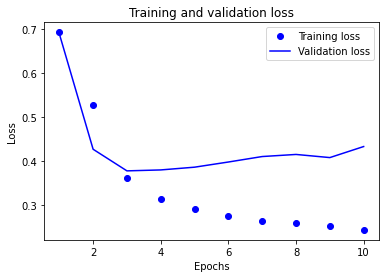

In [18]:
# LSTM
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

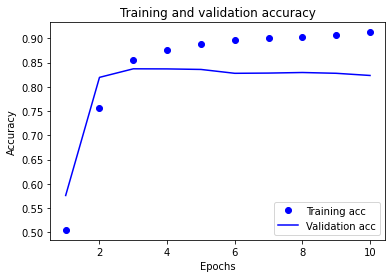

In [19]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

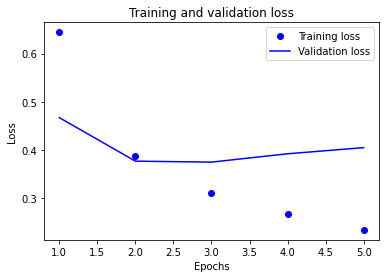

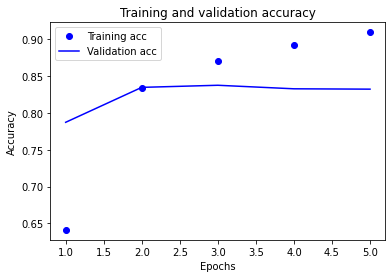

In [20]:
# 1-D CNN
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

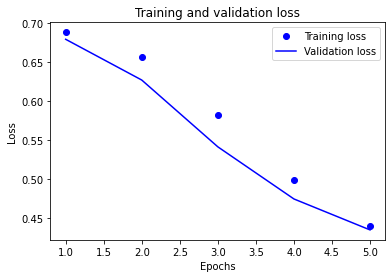

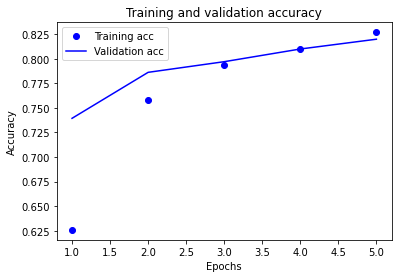

In [21]:
# GlobalAveragePooling1D
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### > 임베딩 레이어 분석

In [22]:
embedding_model = model.layers[0]
weights_model = embedding_model.get_weights()[0]

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]

word2vec_file_path_model = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_model, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_simple = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors_model = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_model, binary=False)

word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

#### > 한국어 Word2Vec 적용

In [23]:
import pprint

path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_vec = Word2Vec.load(path)

print(ko_vec.wv["연기"])
pprint.pprint(ko_vec.wv.most_similar("연기"))

ko_vec = ko_vec.wv

[-5.3693395e-02 -7.8077865e-01  9.6723193e-01 -7.4758315e-01
 -8.9660138e-01 -1.3199822e+00  6.2043767e-04 -6.7502671e-01
  1.3555537e-01 -6.8331599e-01  1.9583182e-01  1.0852404e+00
  2.1468368e-01  2.8309336e-01 -4.0457886e-01 -3.6459949e-02
  5.6666532e-03 -5.4509687e-01  2.2584310e+00 -5.6259340e-01
  6.5086263e-01 -1.8419718e+00 -2.1760310e-01 -1.0132394e+00
  1.5185098e-01 -1.8222044e+00 -1.3982623e+00  1.7238414e+00
 -1.3829633e+00  6.1575718e-02  7.3994440e-01  1.0549146e+00
 -5.4366481e-01  6.0019165e-02  4.3806583e-01 -7.5868535e-01
  1.2300022e+00 -7.9196030e-01 -1.6581323e+00 -3.9155692e-01
 -1.3105632e+00  8.5336879e-02 -2.7811906e-01 -1.2887888e-01
  1.5672020e+00 -1.0730708e-01  3.4074798e-01 -5.3951442e-01
  5.1790684e-01  1.5970176e+00  1.5166098e+00 -1.9613689e-02
 -1.0175781e+00  1.0776117e-02 -4.1133726e-01 -4.0709490e-01
 -1.8630189e-01  1.1953371e+00 -2.0529389e+00  5.4851735e-01
 -1.2525855e+00  2.4897890e-01 -1.0798528e+00  2.5326777e+00
  1.2076815e+00  1.31114

In [24]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 200

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

In [25]:
vocab_size = 10000
word_vector_dim = 200 #https://github.com/Kyubyong/wordvectors 참고. 한국어 word2vec는 벡터 사이즈가 200이다.

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

# one GlobalAveragePooling1D layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))

simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(128, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,185,089
Trainable params: 2,185,089
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
______________________

#### > 모델훈련

In [26]:
epochs = 4

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10

history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
                    
epochs = 8

simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
91/91 [==============================] - 4s 27ms/step - loss: 0.6739 - accuracy: 0.5561 - val_loss: 0.5616 - val_accuracy: 0.7220
Epoch 2/4
91/91 [==============================] - 2s 22ms/step - loss: 0.4831 - accuracy: 0.7761 - val_loss: 0.4240 - val_accuracy: 0.8069
Epoch 3/4
91/91 [==============================] - 2s 22ms/step - loss: 0.3731 - accuracy: 0.8389 - val_loss: 0.3982 - val_accuracy: 0.8284
Epoch 4/4
91/91 [==============================] - 2s 22ms/step - loss: 0.3098 - accuracy: 0.8719 - val_loss: 0.3573 - val_accuracy: 0.8434
Epoch 1/10
91/91 [==============================] - 8s 69ms/step - loss: 0.7854 - accuracy: 0.5888 - val_loss: 0.5684 - val_accuracy: 0.7043
Epoch 2/10
91/91 [==============================] - 5s 59ms/step - loss: 0.5391 - accuracy: 0.7279 - val_loss: 0.4791 - val_accuracy: 0.7725
Epoch 3/10
91/91 [==============================] - 5s 60ms/step - loss: 0.4785 - accuracy: 0.7707 - val_loss: 0.4413 - val_accuracy: 0.7946
Epoch 4/10
91/91 

#### > 모델평가

In [27]:
# LSTM
results_lstm = lstm.evaluate(x_test, y_test, verbose=2)
print('lstm: ', results_lstm)

# 1-D CNN
results_cnn = cnn.evaluate(x_test, y_test, verbose=2)
print('1-D CNN: ', results_cnn)

# one GlobalAveragePooling1D layer
results_simple = simple.evaluate(x_test, y_test, verbose=2)
print('1DLayer: ', results_simple)

1537/1537 - 3s - loss: 0.3627 - accuracy: 0.8401
lstm:  [0.3626585602760315, 0.8401041626930237]
1537/1537 - 3s - loss: 0.4005 - accuracy: 0.8244
1-D CNN:  [0.400485634803772, 0.824440062046051]
1537/1537 - 2s - loss: 0.3813 - accuracy: 0.8335
1DLayer:  [0.3812727630138397, 0.8334926962852478]


#### > 회고

- 이번 프로젝트는 영화 리뷰 데이터를 분석하여 긍정인지 부정인지 감성분석을 하는 것이다.
- 학습된 워드벡터를 이용하지 않았을 때보다 학습된 워드 임베딩을 적용한 모델을 사용 했을때, 정확도가 향상 되었지만 목표치인 85%이상에 도달하지 못했다.
- 파라미터 값을 바꾸니까 더 낮아질때도 있어서 84에 맞추고 종료하였다.
- 한국어 Word2Vec를 불러왔을때, 유사단어 출력은 잘 되는것으로 보였는데, 왜 평가에서는 생각보다 낮은 accuracy가 나오는지 모르겠다.